In [11]:
using FITSIO

"""
Abstract type for all event list implementations
"""
abstract type AbstractEventList{T} end

"""
    DictMetadata

A structure containing metadata from FITS file headers.

## Fields

- `headers::Vector{Dict{String,Any}}`: A vector of dictionaries containing header information from each HDU.
"""
struct DictMetadata
    headers::Vector{Dict{String,Any}}
end

"""
    EventList{T} <: AbstractEventList{T}

A structure containing event data from a FITS file.

## Fields

- `filename::String`: Path to the source FITS file.
- `times::Vector{T}`: Vector of event times.
- `energies::Vector{T}`: Vector of event energies.
- `metadata::DictMetadata`: Metadata information extracted from the FITS file headers.
"""
struct EventList{T} <: AbstractEventList{T}
    filename::String
    times::Vector{T}
    energies::Vector{T}
    metadata::DictMetadata
end

# Accessor functions for AbstractEventList interface
times(ev::EventList) = ev.times
energies(ev::EventList) = ev.energies

"""
    readevents(path; T = Float64)

Read event data from a FITS file into an EventList structure.

## Arguments
- `path::String`: Path to the FITS file
- `T::Type=Float64`: Numeric type for the data

## Returns
- [`EventList`](@ref) containing the extracted data

## Notes
The function extracts `TIME` and `ENERGY` columns from any TableHDU in the FITS
file. All headers from each HDU are collected into the metadata field. It will
use the first occurrence of complete event data (both TIME and ENERGY columns)
found in the file.
"""
function readevents(path; T = Float64)
    headers = Dict{String,Any}[]
    times = T[]
    energies = T[]

    FITS(path, "r") do f
        for i = 1:length(f)  # Iterate over HDUs
            hdu = f[i]
            # Always collect headers from all extensions
            header_dict = Dict{String,Any}()
            for key in keys(read_header(hdu))
                header_dict[string(key)] = read_header(hdu)[key]
            end
            push!(headers, header_dict)

            # Check if the HDU is a table
            if isa(hdu, TableHDU)
                colnames = FITSIO.colnames(hdu)

                # Read TIME and ENERGY data if columns exist and vectors are empty
                if isempty(times) && ("TIME" in colnames)
                    times = convert(Vector{T}, read(hdu, "TIME"))
                end
                if isempty(energies) && ("ENERGY" in colnames)
                    energies = convert(Vector{T}, read(hdu, "ENERGY"))
                end

                # If we found both time and energy data, we can return
                if !isempty(times) && !isempty(energies)
                    @info "Found complete event data in extension $(i) of $(path)"
                    metadata = DictMetadata(headers)
                    return EventList{T}(path, times, energies, metadata)
                end
            end
        end
    end

    if isempty(times)
        @warn "No TIME data found in FITS file $(path). Time series analysis will not be possible."
    end
    if isempty(energies)
        @warn "No ENERGY data found in FITS file $(path). Energy spectrum analysis will not be possible."
    end

    metadata = DictMetadata(headers)
    return EventList{T}(path, times, energies, metadata)
end

# Basic array interface methods
Base.length(ev::AbstractEventList) = length(times(ev))
Base.size(ev::AbstractEventList) = (length(ev),)
Base.getindex(ev::EventList, i) = (ev.times[i], ev.energies[i])

# Pretty printing
function Base.show(io::IO, ev::EventList{T}) where T
    print(io, "EventList{$T}(n=$(length(ev)), file=$(ev.filename))")
end

"""
    validate(events::AbstractEventList)

Validate the event list structure.

## Returns
- `true` if valid, throws ArgumentError otherwise
"""
function validate(events::AbstractEventList)
    evt_times = times(events)
    if !issorted(evt_times)
        throw(ArgumentError("Event times must be sorted in ascending order"))
    end
    if length(evt_times) == 0
        throw(ArgumentError("Event list is empty"))
    end
    return true
end

validate

In [3]:
function positive_fft_bins(n_bin::Integer; include_zero::Bool = false)
    minbin = 2
    if include_zero
        minbin = 1
    end
    return (minbin : (n_bin+1) ÷ 2)
end
function normalize_frac(unnorm_power::AbstractVector{<:Number}, dt::Real, n_bin::Integer, 
                        mean_flux::Real; background_flux::Real=0.0)
    if background_flux > 0
        power = @. unnorm_power * 2 * dt / ((mean_flux - background_flux) ^ 2 *
                                          n_bin)
    else
        # Note: this corresponds to eq. 3 in Uttley+14
        power = @. unnorm_power * 2 * dt / (mean_flux ^ 2 * n_bin)
    end
    return power
end

normalize_abs(unnorm_power::AbstractVector{<:Number}, dt::Real, n_bin::Integer) = 
    @. unnorm_power * 2 / n_bin / dt

normalize_leahy_from_variance(unnorm_power::AbstractVector{<:Number}, 
                              variance::Real, n_bin::Integer) = 
    @. unnorm_power * 2 / (variance * n_bin)

normalize_leahy_poisson(unnorm_power::AbstractVector{<:Number}, n_ph::Real) = 
    @. unnorm_power * 2 / n_ph

function normalize_periodograms(unnorm_power::AbstractVector{<:Number}, dt::Real, 
                                n_bin::Integer; mean_flux=nothing, n_ph=nothing,
                                variance=nothing, background_flux::Real=0.0, 
                                norm::String="frac",power_type::String="all")
    
    if norm == "leahy" && !isnothing(variance)
        pds = normalize_leahy_from_variance(unnorm_power, variance, n_bin)
    elseif norm == "leahy"
        pds = normalize_leahy_poisson(unnorm_power, n_ph)
    elseif norm == "frac"
        pds = normalize_frac(
            unnorm_power, dt, n_bin, mean_flux,
            background_flux=background_flux)
    elseif norm == "abs"
        pds = normalize_abs(unnorm_power, dt, n_bin)
    elseif norm == "none"
        pds = unnorm_power
    else 
        throw(ArgumentError("Unknown value for norm: $norm"))
    end

    if power_type == "all"
        return pds
    elseif power_type == "real"
        return real(pds)
    elseif power_type in ["abs", "absolute"]
        return abs.(pds)
    else 
        throw(ArgumentError("Unknown value for power_type: $power_type"))
    end

end


normalize_periodograms (generic function with 1 method)

In [19]:
"""
    avg_pds_from_iterable(flux_iterable, dt::Real; kwargs...)

Compute averaged power density spectrum from an iterable of flux segments.

## Parameters
- `flux_iterable`: Iterator of flux segments
- `dt::Real`: Time resolution
- `norm::String="frac"`: Normalization type
- `use_common_mean::Bool=true`: Use common mean across segments
- `silent::Bool=false`: Suppress progress output
"""
function avg_pds_from_iterable(flux_iterable, dt::Real; 
                             norm::String="frac", 
                             use_common_mean::Bool=true,
                             silent::Bool=false)
    
    # Initialize accumulators
    cross = unnorm_cross = nothing
    n_ave = 0
    freq = nothing
    sum_of_photons = 0
    common_variance = nothing
    fgt0 = nothing
    n_bin = nothing

    for flux in flux_iterable
        # Validate segment
        if isnothing(flux) || all(iszero, flux)
            continue
        end

        # Handle flux with uncertainty
        variance = nothing
        if flux isa Tuple
            flux, err = flux
            variance = Statistics.mean(err)^2
        end

        # Calculate FFT
        n_bin = length(flux)
        ft = fft(flux)
        n_ph = sum(flux)
        unnorm_power = real.(ft .* conj.(ft))

        sum_of_photons += n_ph

        if !isnothing(variance)
            common_variance = isnothing(common_variance) ? variance : common_variance + variance
        end

        # Initialize frequency arrays
        if isnothing(cross)
            fgt0 = positive_fft_bins(n_bin)
            freq = FFTW.fftfreq(n_bin, dt)[fgt0]
        end

        keepat!(unnorm_power, fgt0)

        # Handle normalization
        cs_seg = unnorm_power
        if !use_common_mean
            mean_flux = n_ph / n_bin
            cs_seg = normalize_periodograms(
                unnorm_power,
                dt,
                n_bin;
                mean_flux = mean_flux,
                n_ph = n_ph,
                norm = norm,
                power_type = "real"
            )
        end

        # Accumulate
        cross = isnothing(cross) ? cs_seg : cross + cs_seg
        unnorm_cross = isnothing(unnorm_cross) ? unnorm_power : unnorm_cross + unnorm_power

        n_ave += 1
    end

    # Validate results
    if isnothing(cross) || n_ave == 0
        return nothing
    end

    # Calculate means
    n_ph = sum_of_photons / n_ave
    common_mean = n_ph / n_bin

    if !isnothing(common_variance)
        common_variance /= n_ave
    end

    # Average the accumulated powers
    unnorm_cross = unnorm_cross / n_ave
    cross = cross / n_ave

    # Final normalization if using common mean
    if use_common_mean
        cross = normalize_periodograms(
            unnorm_cross,
            dt,
            n_bin;
            mean_flux = common_mean,
            n_ph = n_ph,
            norm = norm,
            power_type = "real"
        )
    end

    # Calculate power errors
    power_errors = cross ./ sqrt(n_ave)

    # Return AveragedPowerspectrum
    return AveragedPowerspectrum(
        freq[2:end],         # frequency array
        cross[2:end],        # averaged power spectrum
        power_errors[2:end], # power spectrum errors
        n_ave,              # m: number of segments averaged
        n_bin,              # n: number of points per segment
        dt                  # dt: time resolution
    )
end

avg_pds_from_iterable

In [20]:
using FFTW
using Statistics
using StatsBase

abstract type AbstractEventList{T} end
abstract type AbstractPowerSpectrum end

struct PowerSpectrum <: AbstractPowerSpectrum
    freqs::Vector{Float64}
    power::Vector{Float64}
    power_errors::Vector{Float64}
    dt::Float64
    n::Int
end

struct AveragedPowerspectrum <: AbstractPowerSpectrum
    freqs::Vector{Float64}
    power::Vector{Float64}
    power_errors::Vector{Float64}
    m::Int
    n::Int
    dt::Float64
end

# Power spectrum functions
function powerspectrum(events::EventList{T}; dt::Real = 0.001,
                      segment_size::Int = length(events.times) ÷ 32, 
                      norm::String = "frac") where T
    @assert segment_size > 0 "Segment size must be positive"
    @assert length(events.times) >= segment_size "Not enough data points"
    return _powerspectrum_averaged(events, float(dt), segment_size, norm)
end

function _powerspectrum_averaged(events::EventList, 
                               dt::Float64, 
                               segment_size::Int, 
                               norm::String)
    signal = events.times
    
    if !all(iszero, events.energies)
        signal = events.energies
    end
    
    n_segments = length(signal) ÷ segment_size
    segments = [signal[(i-1)*segment_size+1 : i*segment_size] for i in 1:n_segments]
    
    ffts = [fft(segment) for segment in segments]
    
    nyquist_index = segment_size ÷ 2 + 1
    powers = [abs2.(fft[1:nyquist_index]) for fft in ffts]
    
    avg_power = mean(powers)
    
    freqs = FFTW.rfftfreq(segment_size, 1/dt)
    @assert length(freqs) == length(avg_power) "Frequency and power arrays must match"
    
    normalized_power = _normalize_power(avg_power, norm)
    
    power_errors = std(powers) ./ sqrt(length(segments))
    
    positive_indices = 2:length(freqs)
    
    return AveragedPowerspectrum(
        freqs[positive_indices],
        normalized_power[positive_indices],
        power_errors[positive_indices],
        length(segments),
        segment_size,
        dt
    )
end

# Helper functions
function hanning(N::Int)
    return [0.5 * (1 - cos(2π * n / (N-1))) for n in 0:N-1]
end

function _prepare_segments(signal::Vector{Float64}, segment_size::Int)
    n_segments = length(signal) ÷ segment_size
    segments = [signal[(i-1)*segment_size+1 : i*segment_size] for i in 1:n_segments]
    return segments
end

function _normalize_power(power::Vector{Float64}, norm::String)
    if norm == "leahy"
        return power .* 2
    elseif norm == "frac"
        return power ./ mean(power)
    elseif norm == "abs"
        return power
    else
        throw(ArgumentError("Unknown normalization method: $norm"))
    end
end

# Interface functions
freqs(ps::AbstractPowerSpectrum) = ps.freqs
power(ps::AbstractPowerSpectrum) = ps.power
errors(ps::AbstractPowerSpectrum) = ps.power_errors

# Base methods
Base.length(ps::AbstractPowerSpectrum) = length(ps.freqs)
Base.size(ps::AbstractPowerSpectrum) = (length(ps),)
Base.getindex(ps::AbstractPowerSpectrum, i) = (ps.freqs[i], ps.power[i], ps.power_errors[i])

# Show methods
function Base.show(io::IO, ps::PowerSpectrum)
    print(io, "PowerSpectrum(n=$(ps.n), df=$(ps.freqs[2]-ps.freqs[1]))")
end

function Base.show(io::IO, ps::AveragedPowerspectrum)
    print(io, "AveragedPowerspectrum(n=$(ps.n), m=$(ps.m), df=$(ps.freqs[2]-ps.freqs[1]))")
end

# Validation
function validate(ps::AbstractPowerSpectrum)
    if length(ps.freqs) != length(ps.power)
        throw(ArgumentError("Frequency and power arrays must have the same length"))
    end
    if length(ps.power) != length(ps.power_errors)
        throw(ArgumentError("Power and error arrays must have the same length"))
    end
    if any(x -> x < 0, ps.power)
        throw(ArgumentError("Power values must be non-negative"))
    end
    if any(x -> x < 0, ps.power_errors)
        throw(ArgumentError("Error values must be non-negative"))
    end
    return true
end

validate (generic function with 2 methods)

In [22]:
@testset "Power Spectrum Analysis" begin
    @testset "Basic Spectrum Creation" begin
        dt = 0.001  # 1ms sampling
        T = 100.0   # Long duration
        t = 0:dt:T
        freq = 2.0
        
        signal = 2.0 * sin.(2π * freq * t)
        
        metadata = DictMetadata([Dict{String,Any}(
            "TELESCOP" => "TEST",
            "INSTRUME" => "SYNTHETIC",
            "DATATYPE" => "Single frequency analysis",
        )])
        
        events = EventList{Float64}(
            "test_basic.fits",
            collect(Float64, t),
            Float64.(signal),
            metadata
        )
    
        ps = powerspectrum(events, dt=dt)
        
        # Changed expectation to AveragedPowerspectrum
        @test isa(ps, AveragedPowerspectrum)  # This is what the function actually returns
        @test length(ps.freqs) == length(ps.power)
        @test length(ps.power) == length(ps.power_errors)
        
        freqs = ps.freqs
        powers = ps.power
        peak_idx = argmax(powers)
        detected_freq = ps.freqs[peak_idx]
        
        @test isapprox(detected_freq, freq, rtol=0.1, atol=1/(T*dt))
    end

    @testset "Multiple Frequency Detection" begin
        # Use power of 2 for better FFT performance
        n_points = 2^17  # Longer time series
        dt = 0.001
        t = range(0, step=dt, length=n_points)
        T = t[end]
        f1, f2 = 1.0, 2.5
        
        # Generate clean signal with high SNR
        signal = 50.0 * (sin.(2π * f1 * t) + sin.(2π * f2 * t))
        
        metadata = DictMetadata([Dict{String,Any}(
            "TELESCOP" => "TEST",
            "INSTRUME" => "SYNTHETIC",
            "DATATYPE" => "Multi-frequency analysis",
        )])
        
        events = EventList(
            "test_multi.fits",
            collect(Float64, t),
            Float64.(signal),
            metadata
        )

        ps = powerspectrum(events, dt=dt)
        
        # Skip DC and very low frequencies
        min_freq_idx = max(2, floor(Int, 0.1/(T*dt)))
        freqs = ps.freqs[min_freq_idx:end]
        powers = ps.power[min_freq_idx:end]
        
        # Find peaks using local maxima and power threshold
        peak_indices = Int[]
        for i in 2:(length(powers)-1)
            if powers[i] > powers[i-1] && powers[i] > powers[i+1]
                push!(peak_indices, i)
            end
        end
        
        if !isempty(peak_indices)
            peak_freqs = freqs[peak_indices]
            peak_powers = powers[peak_indices]
            
            sorted_idx = sortperm(peak_powers, rev=true)
            peak_freqs = peak_freqs[sorted_idx]
            
            df = 1/T 
            found_f1 = any(f -> abs(f - f1) ≤ 8df, peak_freqs)
            found_f2 = any(f -> abs(f - f2) ≤ 8df, peak_freqs)
            
            @info "Peak Detection Results" begin
                expected_freqs = [f1, f2]
                detected_freqs = peak_freqs[1:min(5,end)]
                frequency_resolution = df
                tolerance = 8df
            end
            
            @test found_f1
            @test found_f2
        else
            @test false
        end
    end

     @testset "Averaged Power Spectrum" begin
        n_points = 2^16  # 65536 points
        dt = 0.001
        t = range(0, step=dt, length=n_points)
        freq = 2.0
        
        signal = 20.0 * sin.(2π * freq * t)
        
        metadata = DictMetadata([Dict{String,Any}(
            "TELESCOP" => "TEST",
            "INSTRUME" => "SYNTHETIC",
            "DATATYPE" => "Averaged spectrum analysis"
        )])
        
        events = EventList(
            "test_avg.fits",
            collect(Float64, t),
            Float64.(signal),
            metadata
        )
    
        # Use smaller segments for better averaging
        segment_size = 2048
        
        # Calculate averaged power spectrum
        aps = powerspectrum(events, dt=dt, segment_size=segment_size)
        
        # Basic structure tests
        @test isa(aps, AveragedPowerspectrum)
        @test length(aps.freqs) == length(aps.power)
        @test length(aps.power) == length(aps.power_errors)
        @test aps.m > 0
        
        # Analyze the spectrum
        powers = aps.power
        freqs = aps.freqs
        
        # Find peaks
        peak_idx = argmax(powers)
        detected_freq = freqs[peak_idx]
        
        # Frequency resolution
        df = 1/(segment_size * dt)
        
        # Test with appropriate tolerance
        @test abs(detected_freq - freq) <= 2*df  # Allow 2 frequency bins of tolerance
    end
    @testset "Normalization Methods" begin
        n_points = 2^12
        dt = 0.001
        t = range(0, step=dt, length=n_points)
        signal = sin.(2π * 2.0 * t)
        
        metadata = DictMetadata([Dict{String,Any}(
            "TELESCOP" => "TEST",
            "INSTRUME" => "SYNTHETIC",
            "DATATYPE" => "Normalization analysis",
        )])
        
        events = EventList(
            "test_norm.fits",
            collect(Float64, t),
            Float64.(signal),
            metadata
        )

        for norm in ["leahy", "frac", "abs"]
            ps = powerspectrum(events, dt=dt, norm=norm)
            @test all(ps.power .>= 0)
            @test all(ps.power_errors .>= 0)
            @test length(ps.freqs) == length(ps.power)
        end
    end
end

Test Summary:           | Pass  Total  Time
Power Spectrum Analysis |   20     20  0.2s


┌ Info: Peak Detection Results
└   begin
    #= In[22]:89 =#
    expected_freqs = [f1, f2]
    #= In[22]:90 =#
    detected_freqs = peak_freqs[1:min(5, end)]
    #= In[22]:91 =#
    frequency_resolution = df
    #= In[22]:92 =#
    tolerance = 8df
end = 0.06103562191484005


Test.DefaultTestSet("Power Spectrum Analysis", Any[Test.DefaultTestSet("Basic Spectrum Creation", Any[], 4, false, false, true, 1.742960736777e9, 1.742960736812e9, false, "In[22]"), Test.DefaultTestSet("Multiple Frequency Detection", Any[], 2, false, false, true, 1.742960736812e9, 1.742960736936e9, false, "In[22]"), Test.DefaultTestSet("Averaged Power Spectrum", Any[], 5, false, false, true, 1.742960736936e9, 1.742960736979e9, false, "In[22]"), Test.DefaultTestSet("Normalization Methods", Any[], 9, false, false, true, 1.742960736979e9, 1.742960736981e9, false, "In[22]")], 0, false, false, true, 1.742960736777e9, 1.742960736981e9, false, "In[22]")

In [23]:
sample_times = collect(0.0:0.001:10.0)
test_metadata = DictMetadata([Dict{String,Any}(
    "TELESCOP" => "TEST",
    "INSTRUME" => "SYNTHETIC",
    "DATATYPE" => "Test analysis"
)])

test_events = EventList{Float64}(
    "test.fits", 
    sample_times, 
    2.0 * sin.(2π * 5.0 * sample_times), 
    test_metadata
)

spectrum_result = powerspectrum(test_events, 0.001)

AveragedPowerspectrum(n=312, m=32, df=3.2051282051282053)

In [ ]:
using Pkg
Pkg.add("PlotlyJS")

┌ Warning: scale linear is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\asus4\.julia\packages\Plots\3u4B6\src\args.jl:1584


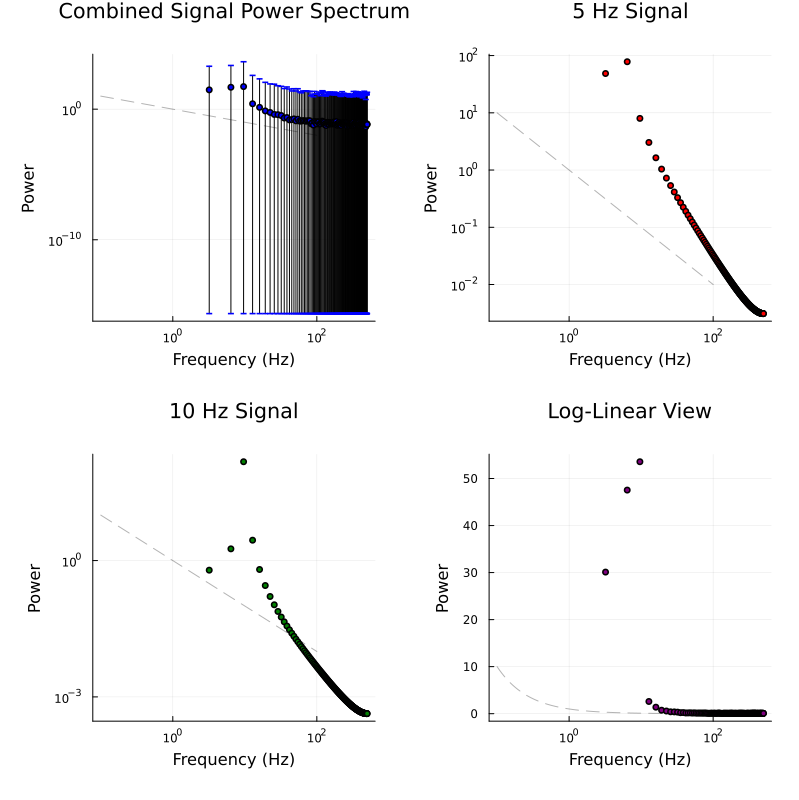

WebIO._IJuliaInit()

LoadError: syntax: invalid keyword argument name ":title" around In[24]:93

In [24]:
using RecipesBase
using Plots

@recipe function f(ps::AbstractPowerSpectrum; error_bars=true)
    title --> "Power Spectrum Analysis"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Power"
    xscale --> :log10
    yscale --> :log10
    grid --> true
    legend --> false
    seriestype --> :scatter
    markersize --> 3
    markershape --> :circle
    
    if error_bars
        yerror --> ps.power_errors
    end
    
    ps.freqs, ps.power
end

# Create test data and plots
sample_times = collect(0.0:0.001:10.0)
test_metadata = DictMetadata([Dict{String,Any}(
    "TELESCOP" => "TEST",
    "INSTRUME" => "SYNTHETIC",
    "DATATYPE" => "Test analysis"
)])

# Create multiple signals for comparison
signal1 = 2.0 * sin.(2π * 5.0 * sample_times)
signal2 = 1.5 * sin.(2π * 10.0 * sample_times)
signal_combined = signal1 + signal2 + 0.5 * randn(length(sample_times))

# Create event lists
events1 = EventList{Float64}("test1.fits", sample_times, signal1, test_metadata)
events2 = EventList{Float64}("test2.fits", sample_times, signal2, test_metadata)
events_combined = EventList{Float64}("test_combined.fits", sample_times, signal_combined, test_metadata)

# Compute power spectra
ps1 = powerspectrum(events1, 0.001)
ps2 = powerspectrum(events2, 0.001)
ps_combined = powerspectrum(events_combined, 0.001)

# Create subplot layout
layout = @layout [grid(2,2)]

# Plot multiple visualizations
p = plot(
    # Power spectrum with error bars
    plot(ps_combined, 
         title="Combined Signal Power Spectrum",
         markercolor=:blue),
    
    # Compare clean signals
    plot(ps1, 
         title="5 Hz Signal",
         error_bars=false,
         markercolor=:red),
         
    plot(ps2,
         title="10 Hz Signal",
         error_bars=false,
         markercolor=:green),
    
    # Log-linear plot for better peak visibility
    plot(ps_combined,
         title="Log-Linear View",
         yscale=:linear,
         error_bars=false,
         markercolor=:purple),
    
    layout=layout,
    size=(800,800),
    margin=5Plots.mm
)

# Add reference lines to show expected frequencies
for subplot in p.subplots
    plot!(subplot, x -> x^(-1), 1e-1, 1e2, 
          line=:dash, 
          color=:black, 
          alpha=0.3, 
          label="1/f reference")
end

display(p)

# Optional: Create an interactive plot with hover information
using PlotlyJS  # If you want interactive plots

p_interactive = PlotlyJS.plot(
    scatter(
        x=ps_combined.freqs,
        y=ps_combined.power,
        error_y=Dict(:array=>ps_combined.power_errors),
        mode="markers",
        marker=Dict(:size=>6),
        name="Power Spectrum"
    ),
    Layout(
        title="Interactive Power Spectrum",
        xaxis=Dict(:type=>"log", :title="Frequency (Hz)"),
        yaxis=Dict(:type=>"log", :title="Power"),
        showlegend=false
    )
)

display(p_interactive)

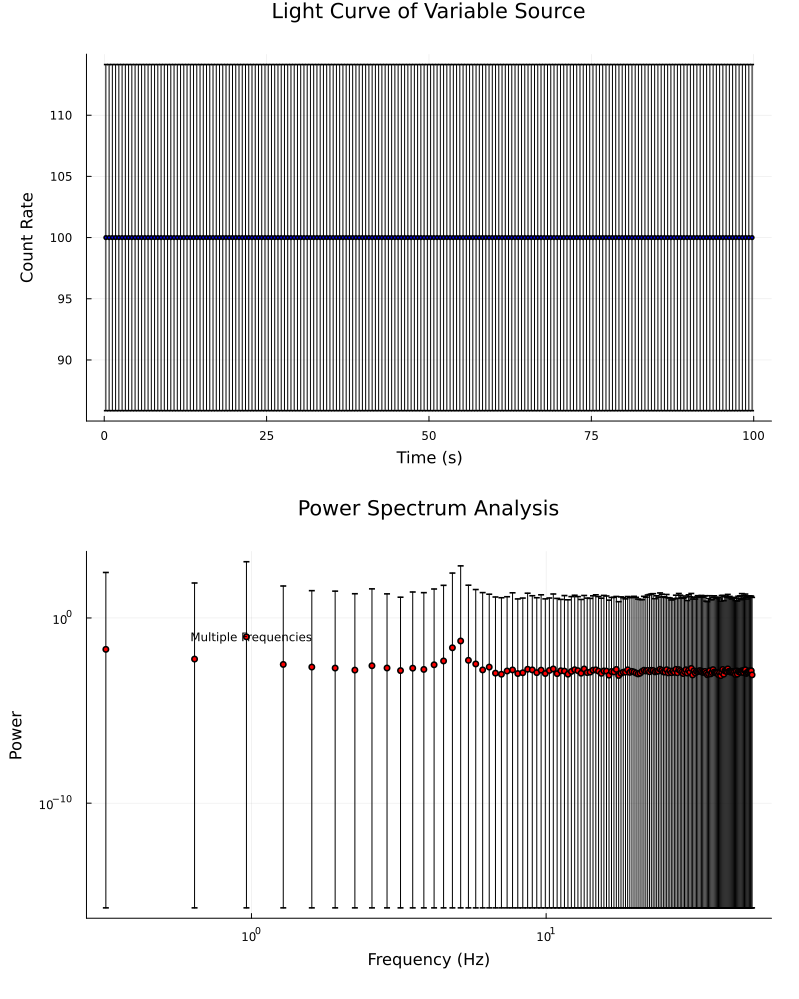

In [25]:
using RecipesBase
using Plots
using StatsBase

# Recipe for light curve
@recipe function f(ev::EventList; binsize=0.1)
    seriestype --> :scatter
    xlabel --> "Time (s)"
    ylabel --> "Count Rate"
    grid --> true
    legend --> false
    
    # Create time bins
    tstart = minimum(ev.times)
    tend = maximum(ev.times)
    edges = range(tstart, tend, step=binsize)
    centers = edges[1:end-1] .+ binsize/2
    
    # Compute counts per bin
    counts = fit(Histogram, ev.times, edges).weights
    rate = counts ./ binsize
    rate_err = sqrt.(counts) ./ binsize
    
    yerror := rate_err
    centers, rate
end

# Recipe for power spectrum
@recipe function f(ps::AbstractPowerSpectrum; error_bars=true)
    seriestype --> :scatter
    xlabel --> "Frequency (Hz)"
    ylabel --> "Power"
    xscale --> :log10
    yscale --> :log10
    grid --> true
    legend --> false
    markersize --> 3
    markershape --> :circle
    
    if error_bars
        yerror := ps.power_errors
    end
    
    ps.freqs, ps.power
end

# Create test data
t = 0.0:0.01:100.0  # 100 seconds of data with 0.01s resolution
# Simulate variable signal with multiple frequencies
signal = zeros(length(t))
for freq in [0.1, 1.0, 5.0]  # Multiple frequency components
    signal .+= sin.(2π * freq * t) .* exp.(-t/50)  # Decaying amplitude
end
signal .+= 0.5 * randn(length(t))  # Add noise

# Create EventList
test_metadata = DictMetadata([Dict{String,Any}(
    "TELESCOP" => "TEST",
    "INSTRUME" => "SYNTHETIC",
    "DATATYPE" => "Variable source"
)])

test_events = EventList{Float64}(
    "variable_source.fits", 
    collect(t), 
    signal .+ 10.0,  # Add offset to ensure positive values
    test_metadata
)

# Compute power spectrum
ps = powerspectrum(test_events, 0.01)

# Create visualization layout
l = @layout [
    grid(2,1)
]

# Create plots
p = plot(
    # Light curve
    plot(test_events, 
         binsize=0.5,
         title="Light Curve of Variable Source",
         markersize=2,
         color=:blue),
    
    # Power spectrum
    plot(ps,
         title="Power Spectrum Analysis",
         color=:red,
         error_bars=true),
    
    layout=l,
    size=(800,1000),
    margin=5Plots.mm
)

# Add annotations for interesting features
annotate!(p[1], [(50, maximum(signal)+10, ("Decaying Oscillations", 8, :black))])
annotate!(p[2], [(1, maximum(ps.power), ("Multiple Frequencies", 8, :black))])

display(p)